In [1]:
# importing the necessary libraries 

%matplotlib inline 
import matplotlib.pyplot as plt 
import seaborn as sns 

import pandas as pd 
import numpy as np
from pylab import rcParams 

import tensorflow as tf 
from tensorflow.keras.models import Model, load_model 
from tensorflow.keras.layers import Input, Dense 
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard 
from tensorflow.keras import regularizers 

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, precision_recall_curve
from sklearn.metrics import recall_score, classification_report, auc, roc_curve
from sklearn.metrics import precision_recall_fscore_support, f1_score

from numpy.random import seed 
seed(1)
from tensorflow.compat.v1 import set_random_seed
set_random_seed(2)

SEED = 123 # used to help randomly select the data points 
DATA_SPLIT_PCT = 0.2 

rcParams['figure.figsize'] = 8, 6
LABELS = ["Normal","Break"] # setting the labels 

In [2]:
# readint the dataset 
df = pd.read_csv('processminer-rare-event-mts - data.csv')
df  

,time,y,x1,x2,x3,x4,x5,x6,x7,x8,...,x52,x53,x54,x55,x56,x57,x58,x59,x60,x61
0,5/1/99 0:00,0,0.376665,-4.596435,-4.095756,13.497687,-0.118830,-20.669883,0.000732,-0.061114,...,10.091721,0.053279,-4.936434,-24.590146,18.515436,3.473400,0.033444,0.953219,0.006076,0
1,5/1/99 0:02,0,0.475720,-4.542502,-4.018359,16.230659,-0.128733,-18.758079,0.000732,-0.061114,...,10.095871,0.062801,-4.937179,-32.413266,22.760065,2.682933,0.033536,1.090502,0.006083,0
2,5/1/99 0:04,0,0.363848,-4.681394,-4.353147,14.127998,-0.138636,-17.836632,0.010803,-0.061114,...,10.100265,0.072322,-4.937924,-34.183774,27.004663,3.537487,0.033629,1.840540,0.006090,0
3,5/1/99 0:06,0,0.301590,-4.758934,-4.023612,13.161567,-0.148142,-18.517601,0.002075,-0.061114,...,10.104660,0.081600,-4.938669,-35.954281,21.672449,3.986095,0.033721,2.554880,0.006097,0
4,5/1/99 0:08,0,0.265578,-4.749928,-4.333150,15.267340,-0.155314,-17.505913,0.000732,-0.061114,...,10.109054,0.091121,-4.939414,-37.724789,21.907251,3.601573,0.033777,1.410494,0.006105,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18393,5/28/99 23:58,0,-0.877442,0.786430,0.406426,135.301215,0.112295,26.300392,-0.159185,0.058823,...,-0.773514,-0.752385,2.682413,6.944644,-37.795661,-0.860218,0.010220,0.895685,-0.011242,0
18394,5/29/99 0:00,0,-0.843988,0.633086,0.561918,133.228949,0.141332,25.678597,-0.159185,0.058823,...,-0.773514,-0.752385,2.683338,0.507755,-39.357199,-0.915699,0.010620,0.175348,-0.011235,0
18395,5/29/99 0:02,0,-0.826547,0.450126,0.334582,134.977973,0.170370,25.056801,-0.159185,0.048752,...,-0.773514,-0.752385,2.684263,2.809146,-39.357199,-1.409596,0.013323,0.621020,-0.011228,0
18396,5/29/99 0:04,0,-0.822842,0.419383,0.387263,135.658942,0.199422,24.435005,-0.159185,0.048752,...,-0.773514,-0.752385,2.685189,2.164859,-39.357199,-0.860218,0.012888,1.390902,-0.011221,0


In [3]:
sign = lambda x: (1, -1)[x < 0]

def curve_shift(df, shift_by):
    '''
    This function will shift the binary labels in a dataframe.
    The curve shift will be with respect to the 1s. 
    For example, if shift is -2, the following process
    will happen: if row n is labeled as 1, then
    - Make row (n+shift_by):(n+shift_by-1) = 1.
    - Remove row n.
    i.e. the labels will be shifted up to 2 rows up.
    
    Inputs:
    df       A pandas dataframe with a binary labeled column. 
             This labeled column should be named as 'y'.
    shift_by An integer denoting the number of rows to shift.
    
    Output
    df       A dataframe with the binary labels shifted by shift.
    '''

    vector = df['y'].copy()
    for s in range(abs(shift_by)):
        tmp = vector.shift(sign(shift_by))
        tmp = tmp.fillna(0)
        vector += tmp
    labelcol = 'y'
    # Add vector to the df
    df.insert(loc=0, column=labelcol+'tmp', value=vector)
    # Remove the rows with labelcol == 1.
    df = df.drop(df[df[labelcol] == 1].index)
    # Drop labelcol and rename the tmp col as labelcol
    df = df.drop(labelcol, axis=1)
    df = df.rename(columns={labelcol+'tmp': labelcol})
    # Make the labelcol binary
    df.loc[df[labelcol] > 0, labelcol] = 1

    return df
df = curve_shift(df, -2)
df

,y,time,x1,x2,x3,x4,x5,x6,x7,x8,...,x52,x53,x54,x55,x56,x57,x58,x59,x60,x61
0,0.0,5/1/99 0:00,0.376665,-4.596435,-4.095756,13.497687,-0.118830,-20.669883,0.000732,-0.061114,...,10.091721,0.053279,-4.936434,-24.590146,18.515436,3.473400,0.033444,0.953219,0.006076,0
1,0.0,5/1/99 0:02,0.475720,-4.542502,-4.018359,16.230659,-0.128733,-18.758079,0.000732,-0.061114,...,10.095871,0.062801,-4.937179,-32.413266,22.760065,2.682933,0.033536,1.090502,0.006083,0
2,0.0,5/1/99 0:04,0.363848,-4.681394,-4.353147,14.127998,-0.138636,-17.836632,0.010803,-0.061114,...,10.100265,0.072322,-4.937924,-34.183774,27.004663,3.537487,0.033629,1.840540,0.006090,0
3,0.0,5/1/99 0:06,0.301590,-4.758934,-4.023612,13.161567,-0.148142,-18.517601,0.002075,-0.061114,...,10.104660,0.081600,-4.938669,-35.954281,21.672449,3.986095,0.033721,2.554880,0.006097,0
4,0.0,5/1/99 0:08,0.265578,-4.749928,-4.333150,15.267340,-0.155314,-17.505913,0.000732,-0.061114,...,10.109054,0.091121,-4.939414,-37.724789,21.907251,3.601573,0.033777,1.410494,0.006105,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18393,0.0,5/28/99 23:58,-0.877442,0.786430,0.406426,135.301215,0.112295,26.300392,-0.159185,0.058823,...,-0.773514,-0.752385,2.682413,6.944644,-37.795661,-0.860218,0.010220,0.895685,-0.011242,0
18394,0.0,5/29/99 0:00,-0.843988,0.633086,0.561918,133.228949,0.141332,25.678597,-0.159185,0.058823,...,-0.773514,-0.752385,2.683338,0.507755,-39.357199,-0.915699,0.010620,0.175348,-0.011235,0
18395,0.0,5/29/99 0:02,-0.826547,0.450126,0.334582,134.977973,0.170370,25.056801,-0.159185,0.048752,...,-0.773514,-0.752385,2.684263,2.809146,-39.357199,-1.409596,0.013323,0.621020,-0.011228,0
18396,0.0,5/29/99 0:04,-0.822842,0.419383,0.387263,135.658942,0.199422,24.435005,-0.159185,0.048752,...,-0.773514,-0.752385,2.685189,2.164859,-39.357199,-0.860218,0.012888,1.390902,-0.011221,0


In [4]:
# Remove time column, and the categorical columns
df = df.drop(['time', 'x28', 'x61'], axis=1)

In [5]:
df_train, df_test = train_test_split(df, test_size=DATA_SPLIT_PCT, random_state=SEED)
df_train, df_valid = train_test_split(df_train, test_size=DATA_SPLIT_PCT, random_state=SEED)

df_train_0 = df_train.loc[df['y'] == 0]
df_train_1 = df_train.loc[df['y'] == 1]
df_train_0_x = df_train_0.drop(['y'], axis=1)
df_train_1_x = df_train_1.drop(['y'], axis=1)

df_valid_0 = df_valid.loc[df['y'] == 0]
df_valid_1 = df_valid.loc[df['y'] == 1]
df_valid_0_x = df_valid_0.drop(['y'], axis=1)
df_valid_1_x = df_valid_1.drop(['y'], axis=1)

df_test_0 = df_test.loc[df['y'] == 0]
df_test_1 = df_test.loc[df['y'] == 1]
df_test_0_x = df_test_0.drop(['y'], axis=1)
df_test_1_x = df_test_1.drop(['y'], axis=1)

In [6]:
# Standardization 
scaler = StandardScaler().fit(df_train_0_x)
df_train_0_x_rescaled = scaler.transform(df_train_0_x)
df_valid_0_x_rescaled = scaler.transform(df_valid_0_x)
df_valid_x_rescaled = scaler.transform(df_valid.drop(['y'], axis = 1))
df_test_0_x_rescaled = scaler.transform(df_test_0_x)
df_test_x_rescaled = scaler.transform(df_test.drop(['y'], axis = 1))

In [7]:
# AUTOENCODER CLASSIFIER 
nb_epoch = 200
batch_size = 128 
input_dim = df_train_0_x_rescaled.shape[1] # num of predictor variables 
encoding_dim = 32 
hidden_dim = int(encoding_dim / 2)
learning_rate = 1e-3

input_layer = Input(shape=(input_dim,))
encoder = Dense(encoding_dim, activation="relu", activity_regularizer=regularizers.l1(learning_rate))(input_layer)
encoder = Dense(hidden_dim, activation="relu")(encoder)
decoder = Dense(hidden_dim, activation="relu")(encoder)
decoder = Dense(encoding_dim, activation="relu")(decoder)
decoder = Dense(input_dim, activation="linear")(decoder)
autoencoder = Model(inputs=input_layer, outputs=decoder)
autoencoder.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 59)]              0         
_________________________________________________________________
dense (Dense)                (None, 32)                1920      
_________________________________________________________________
dense_1 (Dense)              (None, 16)                528       
_________________________________________________________________
dense_2 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_3 (Dense)              (None, 32)                544       
_________________________________________________________________
dense_4 (Dense)              (None, 59)                1947      
Total params: 5,211
Trainable params: 5,211
Non-trainable params: 0
___________________________________________________________

In [8]:
#TRAINING 
autoencoder.compile(metrics=['accuracy'], loss='mean_squared_error', optimizer='adam')
cp = ModelCheckpoint(filepath="autoencoder_classifier.h5", save_best_only=True, verbose=0)
tb = TensorBoard(log_dir='./logs', histogram_freq=0, write_graph=True, write_images=True)
history = autoencoder.fit(df_train_0_x_rescaled,
                          df_train_0_x_rescaled, 
                          epochs=nb_epoch, shuffle=True, 
                          validation_data=(df_valid_0_x_rescaled, df_valid_0_x_rescaled), 
                          verbose=1, callbacks=[cp, tb]).history

Train on 11541 samples, validate on 2883 samples
Epoch 1/200
11541/11541 [==============================] - 3s 267us/sample - loss: 0.6239 - accuracy: 0.0983 - val_loss: 0.4157 - val_accuracy: 0.1991
Epoch 2/200
11541/11541 [==============================] - 1s 65us/sample - loss: 0.3476 - accuracy: 0.2597 - val_loss: 0.3107 - val_accuracy: 0.2792
Epoch 3/200
11541/11541 [==============================] - 1s 63us/sample - loss: 0.2791 - accuracy: 0.3566 - val_loss: 0.2608 - val_accuracy: 0.3899
Epoch 4/200
11541/11541 [==============================] - 1s 64us/sample - loss: 0.2441 - accuracy: 0.4012 - val_loss: 0.2359 - val_accuracy: 0.4266
Epoch 5/200
11541/11541 [==============================] - 1s 78us/sample - loss: 0.2240 - accuracy: 0.4377 - val_loss: 0.2206 - val_accuracy: 0.4343
Epoch 6/200
11541/11541 [==============================] - 1s 67us/sample - loss: 0.2098 - accuracy: 0.4532 - val_loss: 0.2066 - val_accuracy: 0.4558
Epoch 7/200
11541/11541 [=========================

Epoch 55/200
11541/11541 [==============================] - 1s 77us/sample - loss: 0.1112 - accuracy: 0.5944 - val_loss: 0.1151 - val_accuracy: 0.5976
Epoch 56/200
11541/11541 [==============================] - 1s 71us/sample - loss: 0.1102 - accuracy: 0.5960 - val_loss: 0.1125 - val_accuracy: 0.5879
Epoch 57/200
11541/11541 [==============================] - 1s 76us/sample - loss: 0.1101 - accuracy: 0.5955 - val_loss: 0.1127 - val_accuracy: 0.5820
Epoch 58/200
11541/11541 [==============================] - 1s 75us/sample - loss: 0.1096 - accuracy: 0.5932 - val_loss: 0.1142 - val_accuracy: 0.5796
Epoch 59/200
11541/11541 [==============================] - 1s 78us/sample - loss: 0.1091 - accuracy: 0.5959 - val_loss: 0.1114 - val_accuracy: 0.5852
Epoch 60/200
11541/11541 [==============================] - 1s 86us/sample - loss: 0.1084 - accuracy: 0.5977 - val_loss: 0.1113 - val_accuracy: 0.5852
Epoch 61/200
11541/11541 [==============================] - 1s 91us/sample - loss: 0.1081 - ac

11541/11541 [==============================] - 1s 74us/sample - loss: 0.0960 - accuracy: 0.6190 - val_loss: 0.0992 - val_accuracy: 0.6022
Epoch 110/200
11541/11541 [==============================] - 1s 69us/sample - loss: 0.0956 - accuracy: 0.6201 - val_loss: 0.1004 - val_accuracy: 0.6150
Epoch 111/200
11541/11541 [==============================] - 1s 69us/sample - loss: 0.0957 - accuracy: 0.6174 - val_loss: 0.0994 - val_accuracy: 0.6191
Epoch 112/200
11541/11541 [==============================] - 1s 73us/sample - loss: 0.0953 - accuracy: 0.6213 - val_loss: 0.0982 - val_accuracy: 0.6153
Epoch 113/200
11541/11541 [==============================] - 1s 69us/sample - loss: 0.0955 - accuracy: 0.6181 - val_loss: 0.0994 - val_accuracy: 0.6191
Epoch 114/200
11541/11541 [==============================] - 1s 72us/sample - loss: 0.0950 - accuracy: 0.6207 - val_loss: 0.0977 - val_accuracy: 0.6084
Epoch 115/200
11541/11541 [==============================] - 1s 70us/sample - loss: 0.0951 - accuracy:

Epoch 163/200
11541/11541 [==============================] - 1s 74us/sample - loss: 0.0902 - accuracy: 0.6298 - val_loss: 0.0929 - val_accuracy: 0.6306
Epoch 164/200
11541/11541 [==============================] - 1s 70us/sample - loss: 0.0906 - accuracy: 0.6290 - val_loss: 0.0960 - val_accuracy: 0.6171
Epoch 165/200
11541/11541 [==============================] - 1s 71us/sample - loss: 0.0904 - accuracy: 0.6329 - val_loss: 0.0948 - val_accuracy: 0.6146
Epoch 166/200
11541/11541 [==============================] - 1s 70us/sample - loss: 0.0902 - accuracy: 0.6335 - val_loss: 0.0935 - val_accuracy: 0.6275
Epoch 167/200
11541/11541 [==============================] - 1s 71us/sample - loss: 0.0899 - accuracy: 0.6303 - val_loss: 0.0933 - val_accuracy: 0.6341
Epoch 168/200
11541/11541 [==============================] - 1s 72us/sample - loss: 0.0901 - accuracy: 0.6288 - val_loss: 0.0926 - val_accuracy: 0.6365
Epoch 169/200
11541/11541 [==============================] - 1s 69us/sample - loss: 0.08

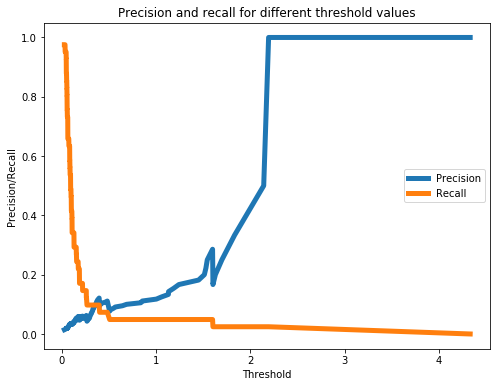

In [10]:
# CLASSIFICATION 
valid_x_predictions = autoencoder.predict(df_valid_x_rescaled)
mse = np.mean(np.power(df_valid_x_rescaled - valid_x_predictions, 2),axis=1)
error_df = pd.DataFrame({'Reconstruction_error':mse,
                        'True_class':df_valid['y']})
precision_rt, recall_rt, threshold_rt = precision_recall_curve(error_df.True_class, error_df.Reconstruction_error)
plt.plot(threshold_rt, precision_rt[1:], label="Precision",linewidth=5)
plt.plot(threshold_rt, recall_rt[1:], label="Recall",linewidth=5)
plt.title('Precision and recall for different threshold values')
plt.xlabel('Threshold')
plt.ylabel('Precision/Recall')
plt.legend()
plt.show()

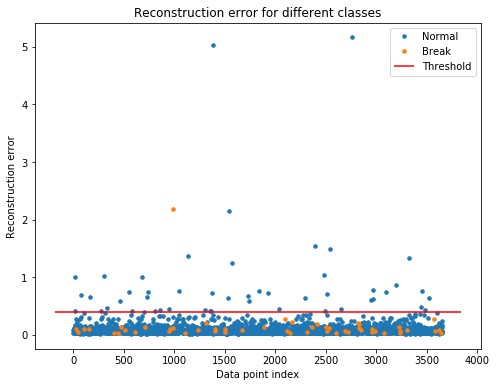

In [11]:
# PERFORMING CLASSIFICATION ON TEST-DATA 
test_x_predictions = autoencoder.predict(df_test_x_rescaled)
mse = np.mean(np.power(df_test_x_rescaled - test_x_predictions, 2), axis=1)
error_df_test = pd.DataFrame({'Reconstruction_error': mse,
                        'True_class': df_test['y']})
error_df_test = error_df_test.reset_index()
threshold_fixed = 0.4
groups = error_df_test.groupby('True_class')
fig, ax = plt.subplots()
for name, group in groups:
    ax.plot(group.index, group.Reconstruction_error, marker='o', ms=3.5, linestyle='',
            label= "Break" if name == 1 else "Normal")
ax.hlines(threshold_fixed, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
ax.legend()
plt.title("Reconstruction error for different classes")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")
plt.show();